<a href="https://colab.research.google.com/github/baovin/ML_homework/blob/main/Copy_of_01_Basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  **Giới thiệu**

Trong bài này, chúng ta sử dụng PyTorch để xây dựng một mạng CNN đơn giản. Sau đó chúng ta sẽ huấn luyện và đánh giá model với tập dữ liệu MNIST nhé.

## Lưu ý về cách làm bài tập
Các bạn điền vào phần **None** và các đoạn code đã được ẩn đi.


### Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

### MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

## **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

## **Setup**

- Chúng ta sẽ setup một số hyper-parameters cũng như một số giá trị cần dùng theo hướng dẫn nhé
- Ở đây, các bạn vào Runtime, chọn Change the runtime type và chọn GPU nhé.

### Hyperparameters

In [2]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch
epochs = 2

# Các tham số cần thiết trong quá trình training
learning_rate = 0.001
batch_size = 128
display_step = 100

# Model path
checkpoint = 'model.pth'

# device: cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Download MNIST dataset in local system

In [3]:
# Định nghĩa tham số transform
transform=transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh sang dạng Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize ảnh với mean và standard deviation là 0.5
    ])

# Load MNIST dataset từ torchvision.datasets
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16813280.24it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 462274.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4214367.83it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10769094.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [5]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


**Visualization of MNIST dataset**

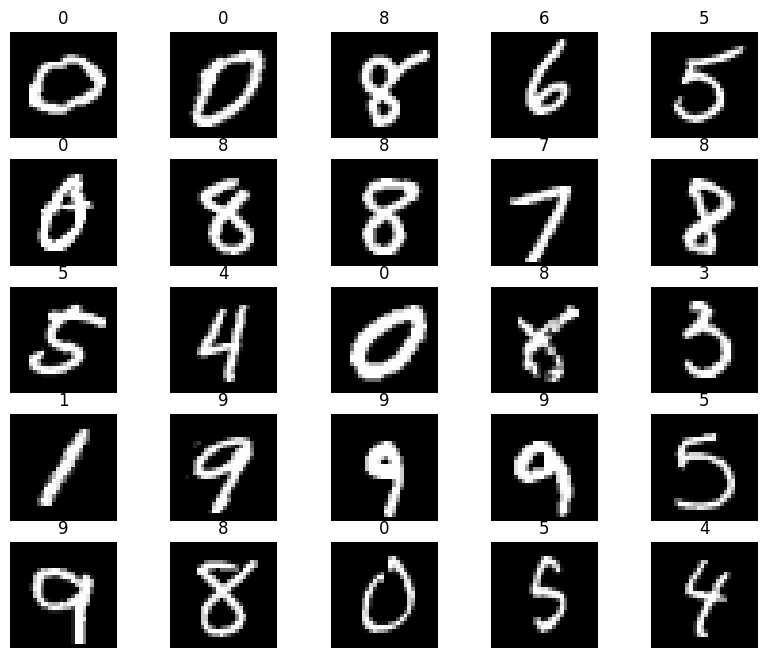

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Preparing data for training with DataLoaders
- Để tiện cho việc xử lý dữ dữ liệu vào các batches cũng như reshuffle dữ liệu qua mỗi epoch thì chúng ta sẽ sử dụng hàm sẵn có của PyTorch là [DataLoader](https://pytorch.org/docs/stable/data.html)

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

## **Model**

- Trong bài này, chúng ta sẽ định nghĩa một class Net để xây dựng một model có cấu trúc như hình ở đầu notebook. Tuy nhiên, ở đây để tránh khả năng bị overfitting của mô hình thì layer `Dropout` sẽ được thêm vào. Mô hình sẽ có cấu trúc như sau: `3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear`
- Kích thước ảnh đầu vào: (28, 28, 1)
- Ở đây, các layer `Conv2d` có các thông số lần lượt là: `filter = (32, 64, 64); kernel_size = 3; stride = 1; valid padding`
- Các layer `Linear` lần lượt số node là `128, 64, num_classes`
- Sau layer `MaxPool2d` thì `height` và `width` của ảnh sẽ giảm đi một nửa
- Hệ số layer `Dropout` = 0.3
- Tham khảo: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten(1,-1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=7744, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        ### START CODE HEAR ≈ 9-18 lines
        ## 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)


        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        ### END CODE HERE
        return x

In [20]:
# Load model vào GPU, ví dụ: input = model().to(device)
model = Net().to(device)
model

Net(
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
test = torch.randn(1, 1, 28, 28).to(device)
output = model(test)
print(output.shape)

torch.Size([1, 10])


## **Training phase**



In [23]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropy
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate) # Adam Optimizer set params=model.parameters(), lr=learning_rate
best_val_loss = 999

# Loop for each epoch
for epoch in range(1, epochs + 1):

    # Quá trình training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Load dữ liệu vào GPU
        data, target = data.to(device), target.to(device)

        # Clear gradients cho mỗi batch
        optimizer.zero_grad() # zero grad
        output = model(data)

        # Backpropagation, tính gradients
        loss = criterion(output, target)
        loss.backward() #backward

        # Apply gradients để update lại tham số
        optimizer.step() #update

        # In ra thông tin về quá trình training
        if batch_idx % display_step == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Quá trình testing
    model.eval()
    test_loss = 0
    correct = 0

    # Set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            # Load dữ liệu vào GPU
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.log_softmax(output,dim=1) # sử dụng hàm log_sotmax của pytorch để tính xác suất cho output, dim = 1
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu model path
      print("***********    TEST_ACC = {:.2f}%    ***********".format(correct/100))

Train Epoch 1: [0/60000 (0%)]	Train Loss: 2.294993
Train Epoch 1: [6400/60000 (11%)]	Train Loss: 0.159533
Train Epoch 1: [12800/60000 (21%)]	Train Loss: 0.179624
Train Epoch 1: [19200/60000 (32%)]	Train Loss: 0.134173
Train Epoch 1: [25600/60000 (43%)]	Train Loss: 0.141813
Train Epoch 1: [32000/60000 (53%)]	Train Loss: 0.120675
Train Epoch 1: [38400/60000 (64%)]	Train Loss: 0.106846
Train Epoch 1: [44800/60000 (75%)]	Train Loss: 0.219081
Train Epoch 1: [51200/60000 (85%)]	Train Loss: 0.282254
Train Epoch 1: [57600/60000 (96%)]	Train Loss: 0.039612
***********    TEST_ACC = 98.43%    ***********
Train Epoch 2: [0/60000 (0%)]	Train Loss: 0.034738
Train Epoch 2: [6400/60000 (11%)]	Train Loss: 0.122841
Train Epoch 2: [12800/60000 (21%)]	Train Loss: 0.016213
Train Epoch 2: [19200/60000 (32%)]	Train Loss: 0.087301
Train Epoch 2: [25600/60000 (43%)]	Train Loss: 0.070412
Train Epoch 2: [32000/60000 (53%)]	Train Loss: 0.097443
Train Epoch 2: [38400/60000 (64%)]	Train Loss: 0.079957
Train Epoch 

In [24]:
# Load lại model đã train
model.load_state_dict(torch.load(checkpoint))

# Xem lại thông số của model
model.eval()

<ipython-input-24-816cd243a513>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


Net(
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## **Prediction**

In [35]:
# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = next(item)

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1, 28, 28)

In [33]:
# Predict sử dụng model đã train
def plot(data, model):
  data = torch.unsqueeze(data, dim=0) # unsqueeze data
  data = data.to(device) # Đưa data vào GPU
  output = model(data)
  output = torch.log_softmax(output, dim=1) # Tính xác suất từng class của output, sử dụng log_softmax, dim = 1
  pred =  output.argmax(keepdim=True)# Lấy class có xác suất cao nhất, keep dim = True, sử dụng argmax
  print("Predict Number : ", pred[0][0].detach().cpu().numpy())
  plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
  plt.show()

Predict Number :  9


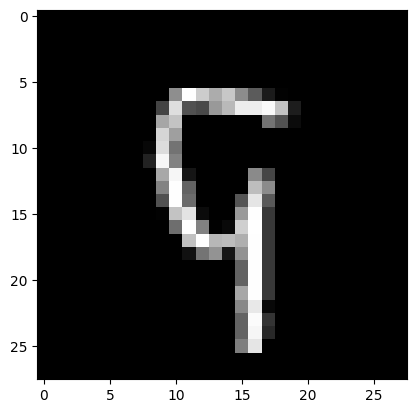

In [36]:
plot(data, model)